In [1]:
import gzip
import json
import random

In [16]:
def load_prism_data_from_jsonl_gz_file(file_path: str, category: str) -> list[dict[str, int]]:
    """
    load a GZ-encoded jsonl file, and extract samples with their corresponding labels
    Parameters:
        - file_path: file path to the GZ-encoded jsonl-file
    Returns:
        - array containing samples with their corresponding labels
    """
    samples = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            sample = json.loads(line)
            sample["category"] = category
            samples.append(sample)
    print(f"Samples for {file_path}: {len(samples)}")
    return samples

In [17]:
def create_balanced_category_samples(human_path: str, ai_path_gpt: str, ai_path_gemma: str, n_total: int, category: str) -> list[dict[str, int]]:
    """
    Create a balanced sample list of size `n_total` with equal human and AI samples.
    Parameters:
        - human_path: file path to the GZ-encoded jsonl-file with human samples
        - ai_path: file path to the GZ-encoded jsonl-file with ai samples
        - n_total: how many examples per file
    Returns:
        - array containing samples with their corresponding labels
    """
    human_samples = load_prism_data_from_jsonl_gz_file(human_path, category)
    ai_samples = load_prism_data_from_jsonl_gz_file(ai_path_gpt, category) + load_prism_data_from_jsonl_gz_file(ai_path_gemma, category)

    #n_per_class = n_total // 2
    #human_samples = random.sample(human_samples, min(n_per_class, len(human_samples)))
    #ai_samples = random.sample(ai_samples, min(n_per_class, len(ai_samples)))

    combined = human_samples + ai_samples
    random.shuffle(combined)
    return combined

In [18]:
samples_per_category = 7000

In [19]:
categories = {
    "arxiv": ("arxiv/human.jsonl.gz", "arxiv/gpt_4o_mini.jsonl.gz", "arxiv/gemma2_9b.jsonl.gz"),
    "blog_authorship_corpus": ("blog_authorship_corpus/human.jsonl.gz", "blog_authorship_corpus/gpt_4o_mini.jsonl.gz", "blog_authorship_corpus/gemma2_9b.jsonl.gz"),
    "bundestag": ("bundestag/human.jsonl.gz", "bundestag/gpt_4o_mini.jsonl.gz", "bundestag/gemma2_9b.jsonl.gz"),
    "cnn": ("cnn/human.jsonl.gz", "cnn/gpt_4o_mini.jsonl.gz", "cnn/gemma2_9b.jsonl.gz"),
    "euro_court": ("euro_court/human.jsonl.gz", "euro_court/gpt_4o_mini.jsonl.gz", "euro_court/gemma2_9b.jsonl.gz"),
    "gutenberg_de": ("gutenberg_de/human.jsonl.gz", "gutenberg_de/gpt_4o_mini.jsonl.gz", "gutenberg_de/gemma2_9b.jsonl.gz"),
    "gutenberg_en": ("gutenberg_en/human.jsonl.gz", "gutenberg_en/gpt_4o_mini.jsonl.gz", "gutenberg_en/gemma2_9b.jsonl.gz"),
    "house_of_commons": ("house_of_commons/human.jsonl.gz", "house_of_commons/gpt_4o_mini.jsonl.gz", "house_of_commons/gemma2_9b.jsonl.gz"),
    "spiegel": ("spiegel/human.jsonl.gz", "spiegel/gpt_4o_mini.jsonl.gz", "spiegel/gemma2_9b.jsonl.gz"),
    "student_essays": ("student_essays/human.jsonl.gz", "student_essays/gpt_4o_mini.jsonl.gz", "student_essays/gemma2_9b.jsonl.gz")
}

In [20]:
all_category_samples = {}

In [21]:
# Für Reproduzierbarkeit
random.seed(42)

In [22]:
for category, (human_path, ai_path_gpt, ai_path_gemma) in categories.items():
    samples = create_balanced_category_samples(human_path, ai_path_gpt, ai_path_gemma, samples_per_category, category)
    all_category_samples[category] = samples
    print(f"{category} samples collected: {len(samples)}")

Samples for arxiv/human.jsonl.gz: 8448
Samples for arxiv/gpt_4o_mini.jsonl.gz: 7173
Samples for arxiv/gemma2_9b.jsonl.gz: 7780
arxiv samples collected: 23401
Samples for blog_authorship_corpus/human.jsonl.gz: 18614
Samples for blog_authorship_corpus/gpt_4o_mini.jsonl.gz: 4576
Samples for blog_authorship_corpus/gemma2_9b.jsonl.gz: 14674
blog_authorship_corpus samples collected: 37864
Samples for bundestag/human.jsonl.gz: 18323
Samples for bundestag/gpt_4o_mini.jsonl.gz: 10057
Samples for bundestag/gemma2_9b.jsonl.gz: 13403
bundestag samples collected: 41783
Samples for cnn/human.jsonl.gz: 18773
Samples for cnn/gpt_4o_mini.jsonl.gz: 11814
Samples for cnn/gemma2_9b.jsonl.gz: 13799
cnn samples collected: 44386
Samples for euro_court/human.jsonl.gz: 9148
Samples for euro_court/gpt_4o_mini.jsonl.gz: 3761
Samples for euro_court/gemma2_9b.jsonl.gz: 8909
euro_court samples collected: 21818
Samples for gutenberg_de/human.jsonl.gz: 372
Samples for gutenberg_de/gpt_4o_mini.jsonl.gz: 100
Samples fo

In [23]:
all_samples = []
for samples in all_category_samples.values():
    all_samples.extend(samples)
print(f"Total collected samples across all categories: {len(all_samples)}")

Total collected samples across all categories: 354738


In [24]:
random.shuffle(all_samples)

In [25]:
dict_by_source = {sample["id_source"]: sample for sample in all_samples}
all_samples = list(dict_by_source.values())
print(len(all_samples))

153037


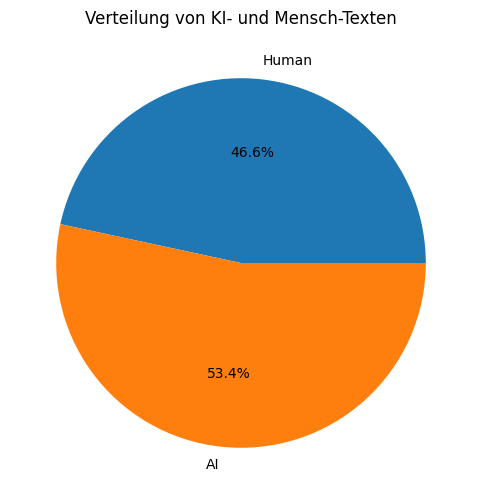

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

labels = [example['label'] for example in all_samples]
label_counts = Counter(labels)

label_names = {0: 'Human', 1: 'AI'}
counts_named = {label_names[k]: v for k, v in label_counts.items()}

# Kreisdiagramm zeichnen
plt.figure(figsize=(6, 6))
plt.pie(counts_named.values(), labels=counts_named.keys(), autopct='%1.1f%%')
plt.title('Verteilung von KI- und Mensch-Texten')
plt.show()

In [27]:
def save_samples_to_jsonl(samples: list[dict[str, int]], output_path: str):
    """
    Save list of samples to a .jsonl file.
    Parameters:
        - samples: to be saved
        - output_path: file path where the file should be saved
    Returns:
        - none
    """
    with open(output_path, 'w', encoding='utf-8') as f:
        for sample in samples:
            json.dump(sample, f, ensure_ascii=False)
            f.write('\n')

In [28]:
save_samples_to_jsonl(all_samples, "dataset_no_dupes.jsonl")

In [ ]:
test = []
with open("dataset_no_dupes.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        test.append(json.loads(line))

print(len(test))